# E-Commerce Fraud Detection

This project models E-Commerce transaction data to identify fraudelent activity, based on this [Kaggle Dataset](https://www.kaggle.com/datasets/umuttuygurr/e-commerce-fraud-detection-dataset). The dataset is synthetic, but very realistic, as it is modeled after real-life fraudulent activity observed in 2024, with scenarios such as
- Cards tested with $1 purchases at midnight
- Transactions that shipped “gaming accessories” 5,000 km away
- Promo codes being reused from freshly created accounts.

I decided to focus on this dataset as it is the most complete, realistic data on transaction fraud that I could find. Other fraud datasets that weren't synthetic had to obfuscate the meaning of features and their values for privacy reasons, using techniques like PCA, so features had meaningless names like V1, V2, etc.

Here is a list of the columns in the dataset with brief descriptions:

- `transaction_id`: Unique transaction identifier
- `user_id`: User identifier (each user 40–60 transactions)
- `account_age_days`: Age of user account in days
- `total_transactions_user`: Number of transactions per user
- `avg_amount_user`: User’s mean transaction amount
- `amount`: Transaction amount (USD)
- `country`: User’s country
- `bin_country`: Country of the card-issuing bank
- `channel`: “web” or “app”
- `merchant_category`: Type of purchase: electronics, fashion, grocery, gaming, travel
- `promo_used`: whether a discount/promo was used
- `avs_flag`: Address Verification result, a mismatch in the billing address provided by a customer and the one on file with their card issuer.
- `cvv_result`: CVV code match result, indicates if 3 digit code on back of card provided during an online transaction matched the card issuer's records
- `three_ds_flag`: 3D Secure enabled, so if a transaction is flagged, it prompts the customer to complete an extra verification step, such as a one-time code sent to your phone, a password, or biometric login
- `transaction_time`: Transaction timestamp (UTC)
- `shipping_distance_km`: Distance between billing and shipping addresses
- `is_fraud`: Target label (1 = fraud, 0 = normal)

## Setup
### Define parameters
The input/output parameters are defined in the next cell.

In [1]:
# Data input parameters
kaggle_source = "umuttuygurr/e-commerce-fraud-detection-dataset"
data_dir = "../data"  # Relative to notebooks/ folder
csv_file = "transactions.csv"
# Column definitions
target_col = "is_fraud"
id_cols = ['transaction_id', 'user_id']
date_feature = 'transaction_time'
# Define categorical features (including binary flags)
categorical_features = ['country', 'bin_country', 'channel', 'merchant_category', 
                       'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
# Define numeric features (continuous/count variables only)
numeric_features = ['account_age_days', 'total_transactions_user', 'avg_amount_user', 
                   'amount', 'shipping_distance_km']
# Validation/Test split ratios
val_ratio = .2
test_ratio = .2

# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

### Import packages

In [ ]:
# Add project root to path for imports (needed when running from notebooks/ folder)
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import EDA and feature engineering utilities from fd1_nb module
from src.fd1_nb import (
    # Data utilities
    download_data_csv,
    load_data,
    split_train_val_test,
    analyze_target_stats,
    analyze_feature_stats,
    # EDA utilities
    plot_numeric_distributions,
    analyze_vif,
    analyze_correlations,
    plot_box_plots,
    analyze_temporal_patterns,
    analyze_categorical_fraud_rates,
    plot_categorical_fraud_rates,
    analyze_mutual_information,
    # Feature engineering
    convert_utc_to_local_time,
    create_temporal_features,
    create_interaction_features,
)

# Standard library imports (still used in notebook)
import pandas as pd

# Utilities for feature configuration
from src.deployment.preprocessing import FeatureConfig

### Define feature engineering functions

In [3]:
# ============ FEATURE ENGINEERING FUNCTIONS ============

def get_country_timezone_mapping():
    """Create mapping of country codes to capital city timezones."""
    return {
        'US': 'America/New_York',      # Washington D.C.
        'GB': 'Europe/London',          # London
        'FR': 'Europe/Paris',           # Paris
        'DE': 'Europe/Berlin',          # Berlin
        'IT': 'Europe/Rome',            # Rome
        'ES': 'Europe/Madrid',          # Madrid
        'NL': 'Europe/Amsterdam',       # Amsterdam
        'PL': 'Europe/Warsaw',          # Warsaw
        'RO': 'Europe/Bucharest',       # Bucharest
        'TR': 'Europe/Istanbul'         # Istanbul
    }

def create_amount_features(df):
    """Create transaction amount-based features."""
    df = df.copy()
    
    # Amount deviation from user's average
    df['amount_deviation'] = (df['amount'] - df['avg_amount_user']).abs()
    
    # Amount ratio compared to user's average (handle division by zero)
    df['amount_vs_avg_ratio'] = df['amount'] / df['avg_amount_user'].replace(0, 1)
    
    # Micro transactions (potential card testing)
    df['is_micro_transaction'] = (df['amount'] <= 5).astype(int)
    
    # Large transactions
    df['is_large_transaction'] = (df['amount'] >= df['amount'].quantile(0.95)).astype(int)
    
    features = ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']
    return df, features

def create_user_behavior_features(df):
    """Create user behavior-based features."""
    df = df.copy()
    
    # Transaction velocity (transactions per day of account age)
    df['transaction_velocity'] = df['total_transactions_user'] / df['account_age_days'].replace(0, 1)
    
    # New account flag (less than 30 days)
    df['is_new_account'] = (df['account_age_days'] <= 30).astype(int)
    
    # High frequency user
    df['is_high_frequency_user'] = (df['total_transactions_user'] >= df['total_transactions_user'].quantile(0.75)).astype(int)
    
    features = ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']
    return df, features

def create_geographic_features(df, risk_distance_quantile=0.75):
    """Create geographic-based features."""
    df = df.copy()
    
    # Country mismatch (user country != card issuing country)
    df['country_mismatch'] = (df['country'] != df['bin_country']).astype(int)
    
    # High risk shipping distance (>75th percentile)
    distance_threshold = df['shipping_distance_km'].quantile(risk_distance_quantile)
    df['high_risk_distance'] = (df['shipping_distance_km'] > distance_threshold).astype(int)
    
    # Zero distance (billing = shipping, lower risk)
    df['zero_distance'] = (df['shipping_distance_km'] == 0).astype(int)
    
    features = ['country_mismatch', 'high_risk_distance', 'zero_distance']
    return df, features

def create_security_features(df):
    """Create security verification-based features."""
    df = df.copy()
    
    # Security score (count of passed verifications)
    df['security_score'] = df['avs_match'] + df['cvv_result'] + df['three_ds_flag']
    
    # Count of failed verifications
    df['verification_failures'] = 3 - df['security_score']
    
    # All verifications passed
    df['all_verifications_passed'] = (df['security_score'] == 3).astype(int)
    
    # All verifications failed (high risk)
    df['all_verifications_failed'] = (df['security_score'] == 0).astype(int)
    
    features = ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']
    return df, features

def engineer_features(df, date_col='transaction_time', country_col='country'):
    """
    Master function to create all engineered features.
    Includes both UTC and local time-based features.
    """
    print("=" * 80)
    print("FEATURE ENGINEERING")
    print("=" * 80)
    
    df_eng = df.copy()
    all_new_features = []
    
    # 1. Convert to local time
    print("\n1. TIMEZONE CONVERSION:")
    df_eng = convert_utc_to_local_time(df_eng, date_col, country_col, timezone_mapping=get_country_timezone_mapping())
    
    # 2. Temporal features (UTC)
    print("\n2. TEMPORAL FEATURES (UTC):")
    df_eng, utc_features = create_temporal_features(df_eng, date_col, suffix='', late_night_hours=(23, 4), business_hours=(9, 17))
    print(f"  ✓ Created {len(utc_features)} UTC temporal features")
    all_new_features.extend(utc_features)
    
    # 3. Temporal features (Local time)
    print("\n3. TEMPORAL FEATURES (LOCAL TIME):")
    df_eng, local_features = create_temporal_features(df_eng, 'local_time', suffix='_local', late_night_hours=(23, 4), business_hours=(9, 17))
    print(f"  ✓ Created {len(local_features)} local time temporal features")
    all_new_features.extend(local_features)
    
    # 4. Amount features
    print("\n4. TRANSACTION AMOUNT FEATURES:")
    df_eng, amount_features = create_amount_features(df_eng)
    print(f"  ✓ Created {len(amount_features)} amount-based features: {amount_features}")
    all_new_features.extend(amount_features)
    
    # 5. User behavior features
    print("\n5. USER BEHAVIOR FEATURES:")
    df_eng, behavior_features = create_user_behavior_features(df_eng)
    print(f"  ✓ Created {len(behavior_features)} behavior features: {behavior_features}")
    all_new_features.extend(behavior_features)
    
    # 6. Geographic features
    print("\n6. GEOGRAPHIC FEATURES:")
    df_eng, geo_features = create_geographic_features(df_eng)
    print(f"  ✓ Created {len(geo_features)} geographic features: {geo_features}")
    all_new_features.extend(geo_features)
    
    # 7. Security features
    print("\n7. SECURITY FEATURES:")
    df_eng, security_features = create_security_features(df_eng)
    print(f"  ✓ Created {len(security_features)} security features: {security_features}")
    all_new_features.extend(security_features)
    
    # 8. Interaction features
    print("\n8. INTERACTION FEATURES (High-Risk Combinations):")
    # Define interaction feature configurations
    interaction_config = [
        {
            'name': 'new_account_with_promo',
            'conditions': ['is_new_account == 1', 'promo_used == 1'],
            'operator': 'and'
        },
        {
            'name': 'late_night_micro_transaction',
            'conditions': ['is_late_night_local == 1', 'is_micro_transaction == 1'],
            'operator': 'and'
        },
        {
            'name': 'foreign_card_failed_verification',
            'conditions': ['country_mismatch == 1', 'verification_failures > 0'],
            'operator': 'and'
        },
        {
            'name': 'new_high_velocity_account',
            'conditions': ['is_new_account == 1', 'is_high_frequency_user == 1'],
            'operator': 'and'
        },
        {
            'name': 'high_value_long_distance',
            'conditions': ['is_large_transaction == 1', 'high_risk_distance == 1'],
            'operator': 'and'
        },
        {
            'name': 'triple_risk_combo',
            'conditions': ['is_new_account == 1', 'promo_used == 1', 'verification_failures > 0'],
            'operator': 'and'
        }
    ]

    df_eng, interaction_features = create_interaction_features(df_eng, interaction_config)
    print(f"  ✓ Created {len(interaction_features)} interaction features: {interaction_features}")
    all_new_features.extend(interaction_features)

    # Summary
    print("\n" + "=" * 80)
    print(f"FEATURE ENGINEERING COMPLETE")
    print(f"Total new features created: {len(all_new_features)}")
    print(f"Original shape: {df.shape}")
    print(f"New shape: {df_eng.shape}")
    print("=" * 80)
    
    return df_eng, all_new_features


def print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features):
    """Print comprehensive feature selection recommendations."""
    print("=" * 80)
    print("FEATURE SELECTION RECOMMENDATIONS")
    print("=" * 80)
    
    print("\n📊 SUMMARY OF EDA FINDINGS:")
    print("-" * 80)
    
    print("\n1. NUMERIC FEATURES (Correlation Analysis):")
    print("   Features to KEEP (showing meaningful correlation):")
    for _, row in corr_df.head(5).iterrows():
        print(f"   ✓ {row['feature']}: {row['correlation']:.4f} correlation")
    
    print("\n2. CATEGORICAL FEATURES (Mutual Information Analysis):")
    print("   Features to KEEP (MI > 0.01):")
    high_mi_features = mi_df[mi_df['mi_score'] > 0.01]
    for _, row in high_mi_features.iterrows():
        print(f"   ✓ {row['feature']}: MI = {row['mi_score']:.4f}")
    
    print("\n3. MULTICOLLINEARITY CHECK:")
    if vif_df['VIF'].max() > 10:
        high_vif_features = vif_df[vif_df['VIF'] > 10]
        print("   ⚠️  Consider removing or combining these features:")
        for _, row in high_vif_features.iterrows():
            print(f"   - {row['feature']}: VIF = {row['VIF']:.2f}")
    else:
        print("   ✓ No severe multicollinearity detected")
    
    print("\n4. TEMPORAL PATTERNS:")
    print("   ✓ Hour of day shows fraud patterns (consider time-based features)")
    print("   ✓ Weekend/weekday distinction may be relevant")
    
    print("\n" + "=" * 80)
    print("RECOMMENDED FEATURES FOR MODELING:")
    print("=" * 80)
    
    print("\n✅ NUMERIC FEATURES (all 5):")
    for feat in numeric_features:
        print(f"   • {feat}")
    
    print("\n✅ CATEGORICAL FEATURES (all 8):")
    for feat in categorical_features:
        print(f"   • {feat}")
    
    print("\n✅ TEMPORAL FEATURES TO ENGINEER:")
    print("   • hour (from transaction_time)")
    print("   • day_of_week (from transaction_time)")
    print("   • is_weekend (derived from day_of_week)")
    print("   • is_midnight (hours 23-01)")
    
    print("\n💡 SUGGESTED FEATURE ENGINEERING:")
    print("   • country_mismatch: (country != bin_country)")
    print("   • amount_deviation: |amount - avg_amount_user|")
    print("   • amount_vs_avg_ratio: amount / avg_amount_user")
    print("   • high_risk_distance: (shipping_distance_km > threshold)")
    print("   • security_score: combination of avs_match + cvv_result + three_ds_flag")
    print("   • transaction_velocity: total_transactions_user / account_age_days")
    
    print("\n⚡ MODELING CONSIDERATIONS:")
    print("   • Use stratified sampling (class imbalance: 44:1)")
    print("   • Apply class weights or SMOTE for minority class")
    print("   • Use appropriate metrics: ROC-AUC, F1, Precision-Recall (not accuracy)")
    print("   • Consider threshold tuning for precision/recall trade-off")
    print("   • Try tree-based models (handle categorical features well)")
    
    print("\n" + "=" * 80)

def analyze_final_feature_selection(train_new_features):
    """
    Comprehensive final feature selection analysis based on EDA insights
    and engineered features. Returns categorized feature recommendations.
    """
    print("=" * 80)
    print("FINAL FEATURE SELECTION FOR MODELING")
    print("=" * 80)

    # Define all available features
    original_numeric = ['account_age_days', 'total_transactions_user', 'avg_amount_user',
                       'amount', 'shipping_distance_km']
    original_categorical = ['country', 'bin_country', 'channel', 'merchant_category',
                           'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

    print("\n📊 AVAILABLE FEATURES:")
    print("-" * 80)
    print(f"Original features: {len(original_numeric) + len(original_categorical)}")
    print(f"  • Numeric: {len(original_numeric)}")
    print(f"  • Categorical: {len(original_categorical)}")
    print(f"Engineered features: {len(train_new_features)}")
    print(f"Total available: {len(original_numeric) + len(original_categorical) + len(train_new_features)}")

    # Categorize engineered features
    temporal_utc = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_late_night', 'is_business_hours']
    temporal_local = ['hour_local', 'day_of_week_local', 'month_local', 'is_weekend_local',
                     'is_late_night_local', 'is_business_hours_local']
    amount_features = ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']
    behavior_features = ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']
    geographic_features = ['country_mismatch', 'high_risk_distance', 'zero_distance']
    security_features = ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']
    interaction_features = ['new_account_with_promo', 'late_night_micro_transaction',
                           'foreign_card_failed_verification', 'new_high_velocity_account',
                           'high_value_long_distance', 'triple_risk_combo']

    print("\n🔍 FEATURE SELECTION ANALYSIS:")
    print("-" * 80)

    # 1. Original Features - Keep high-value ones
    print("\n1. ORIGINAL FEATURES:")
    print("   ✅ KEEP ALL NUMERIC (5):")
    print("      • shipping_distance_km - Strong correlation (0.27)")
    print("      • amount - Moderate correlation (0.20)")
    print("      • account_age_days - Negative correlation (-0.12)")
    print("      • total_transactions_user, avg_amount_user - Baseline info")

    print("\n   ✅ KEEP HIGH-VALUE CATEGORICAL (5 of 8):")
    print("      • avs_match - High MI (0.017), 9.8% fraud when failed")
    print("      • cvv_result - High MI (0.015), 10.6% fraud when failed")
    print("      • three_ds_flag - High MI (0.010), 6.7% fraud when disabled")
    print("      • channel - High signal (3.6% fraud on web vs 0.8% on app)")
    print("      • promo_used - High signal (4.6% fraud when used)")

    print("\n   ⚠️  EXCLUDE (3 of 8) - Redundant with engineered features:")
    print("      • country → Replaced by country_mismatch (more specific)")
    print("      • bin_country → Replaced by country_mismatch")
    print("      • merchant_category → Low signal, all categories near baseline")

    # 2. Temporal Features - Choose local over UTC
    print("\n2. TEMPORAL FEATURES:")
    print("   ✅ KEEP LOCAL TIME FEATURES (6):")
    print("      • hour_local - Better captures 'unusual hour' fraud")
    print("      • is_late_night_local - Fraud scenario #1 (midnight transactions)")
    print("      • is_weekend_local, day_of_week_local, month_local")
    print("      • is_business_hours_local - Inverse of late_night signal")

    print("\n   ⚠️  EXCLUDE UTC FEATURES (6) - Redundant:")
    print("      • Local time is more meaningful for fraud detection")
    print("      • UTC features don't align with human behavior patterns")

    # 3. Amount Features - Keep all
    print("\n3. AMOUNT FEATURES:")
    print("   ✅ KEEP ALL (4):")
    print("      • is_micro_transaction - Fraud scenario #1 ($1 card testing)")
    print("      • amount_vs_avg_ratio - User deviation signal")
    print("      • is_large_transaction - High-value fraud attempts")
    print("      • amount_deviation - Absolute deviation signal")

    # 4. Behavior Features - Keep all
    print("\n4. USER BEHAVIOR FEATURES:")
    print("   ✅ KEEP ALL (3):")
    print("      • is_new_account - Fraud scenario #3 (fresh accounts)")
    print("      • transaction_velocity - Rapid account usage")
    print("      • is_high_frequency_user - Baseline comparison")

    # 5. Geographic Features - Keep all
    print("\n5. GEOGRAPHIC FEATURES:")
    print("   ✅ KEEP ALL (3):")
    print("      • country_mismatch - Replaces country + bin_country")
    print("      • high_risk_distance - Fraud scenario #2 (5000km shipments)")
    print("      • zero_distance - Low-risk indicator")

    # 6. Security Features - Keep composite score only
    print("\n6. SECURITY FEATURES:")
    print("   ✅ KEEP COMPOSITE SCORE (1 of 4):")
    print("      • security_score - Replaces individual avs/cvv/3ds flags")

    print("\n   ⚠️  EXCLUDE (3 of 4) - Redundant:")
    print("      • verification_failures → Inverse of security_score")
    print("      • all_verifications_passed → Encoded in security_score == 3")
    print("      • all_verifications_failed → Encoded in security_score == 0")
    print("      Note: Keep original avs_match, cvv_result, three_ds_flag for interpretability")

    # 7. Interaction Features - Keep scenario-specific only
    print("\n7. INTERACTION FEATURES:")
    print("   ✅ KEEP SCENARIO-SPECIFIC (3 of 6):")
    print("      • new_account_with_promo - Fraud scenario #3 (explicit)")
    print("      • late_night_micro_transaction - Fraud scenario #1 (explicit)")
    print("      • high_value_long_distance - Fraud scenario #2 variant")

    print("\n   ⚠️  EXCLUDE COMPOSITE INTERACTIONS (3 of 6):")
    print("      • foreign_card_failed_verification → Covered by country_mismatch + security_score")
    print("      • new_high_velocity_account → Covered by is_new_account + is_high_frequency_user")
    print("      • triple_risk_combo → Overly specific, low frequency")

    # Final recommendations
    print("\n" + "=" * 80)
    print("FINAL FEATURE SET FOR MODELING")
    print("=" * 80)

    # Build final feature lists
    final_numeric = original_numeric.copy()
    final_categorical = ['channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
    final_temporal = temporal_local.copy()
    final_amount = amount_features.copy()
    final_behavior = behavior_features.copy()
    final_geographic = geographic_features.copy()
    final_security = ['security_score']
    final_interaction = ['new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']

    all_final_features = (final_numeric + final_categorical + final_temporal +
                         final_amount + final_behavior + final_geographic +
                         final_security + final_interaction)

    print(f"\nTotal features selected: {len(all_final_features)} (from {len(original_numeric) + len(original_categorical) + len(train_new_features)} available)")
    print(f"Reduction: {len(original_numeric) + len(original_categorical) + len(train_new_features) - len(all_final_features)} features excluded")

    print("\n📋 FINAL FEATURE LIST BY CATEGORY:")
    print("-" * 80)

    print(f"\n1. Original Numeric ({len(final_numeric)}):")
    for feat in final_numeric:
        print(f"   • {feat}")

    print(f"\n2. Original Categorical ({len(final_categorical)}):")
    for feat in final_categorical:
        print(f"   • {feat}")

    print(f"\n3. Temporal (Local Time) ({len(final_temporal)}):")
    for feat in final_temporal:
        print(f"   • {feat}")

    print(f"\n4. Amount Features ({len(final_amount)}):")
    for feat in final_amount:
        print(f"   • {feat}")

    print(f"\n5. User Behavior ({len(final_behavior)}):")
    for feat in final_behavior:
        print(f"   • {feat}")

    print(f"\n6. Geographic ({len(final_geographic)}):")
    for feat in final_geographic:
        print(f"   • {feat}")

    print(f"\n7. Security ({len(final_security)}):")
    for feat in final_security:
        print(f"   • {feat}")

    print(f"\n8. Interaction (Fraud Scenarios) ({len(final_interaction)}):")
    for feat in final_interaction:
        print(f"   • {feat}")

    print("\n" + "=" * 80)
    print("KEY DECISIONS:")
    print("=" * 80)
    print("✓ Local time > UTC time (better fraud signal)")
    print("✓ country_mismatch > individual country fields (more specific)")
    print("✓ security_score composite > individual flags (reduces dimensionality)")
    print("✓ Kept original avs/cvv/3ds for interpretability despite redundancy")
    print("✓ Scenario-specific interactions > generic combinations")
    print("✓ Excluded merchant_category (low predictive value)")

    print("\n" + "=" * 80)

    return {
        'numeric': final_numeric,
        'categorical': final_categorical,
        'temporal': final_temporal,
        'amount': final_amount,
        'behavior': final_behavior,
        'geographic': final_geographic,
        'security': final_security,
        'interaction': final_interaction,
        'all_features': all_final_features
    }


## Load data

In [4]:
download_data_csv(kaggle_source, data_dir, csv_file)
input_df = load_data(f"{data_dir}/{csv_file}", verbose=True)


Dataset already exists at ../data/transactions.csv

Dataset Shape: 299695 rows, 17 columns

Memory Usage:
107.29 MB


In [5]:
input_df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [6]:
# No null values
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

## Preprocessing
### Verify table grain

In [7]:
print(f"Every row is uniquely defined by transaction and user id columns: {len(input_df)==len(input_df.drop_duplicates(subset=id_cols))}")

Every row is uniquely defined by transaction and user id columns: True


### Target class balance
Target class imbalance is investigated prior to train/validation/test split because stratified splitting is necessary to handle the large class imbalance present in this dataset (only 2.2% fraud). Modeling will require techniques such as stratified sampling, class weights, appropriate metrics, etc.


Target Distribution (%):
is_fraud
0    97.793757
1     2.206243
Name: proportion, dtype: float64



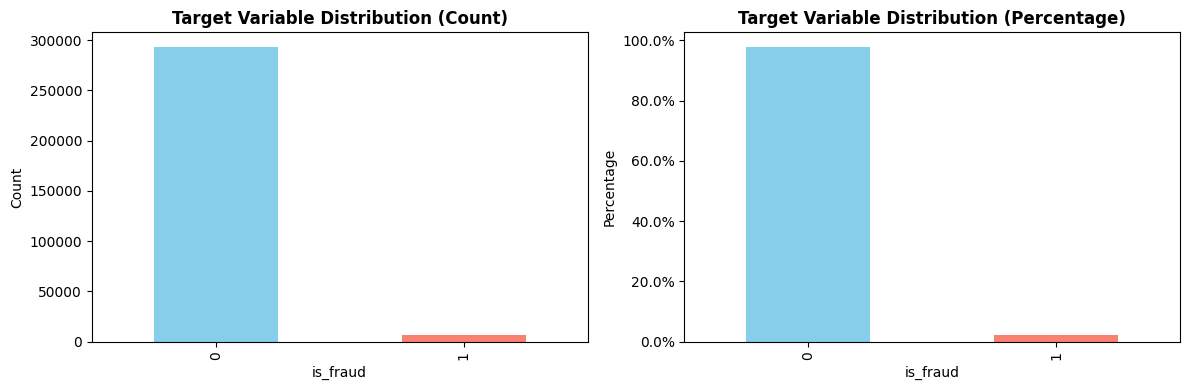

{'distribution': is_fraud
 0    0.977938
 1    0.022062
 Name: proportion, dtype: float64,
 'imbalance_ratio': np.float64(44.325922565033274),
 'is_imbalanced': np.True_}

In [8]:
analyze_target_stats(input_df, target_col)

### Convert date type

In [9]:
# Parse timestamps as UTC timezone-aware (fail if timezone missing)
input_df[date_feature] = pd.to_datetime(input_df[date_feature], utc=True, errors='coerce')

### Feature stats
Examine the distribution of categorical features and compute summary statistics for numerical features. Binary features (0/1 flags) are treated as categorical since they represent discrete states (see Setup, Define parameters section above).

In [10]:
analyze_feature_stats(input_df, id_cols, target_col, categorical_features, numeric_features)


Categorical Features (2): ['transaction_id', 'user_id']

Categorical Features Summary:

transaction_id:
  Unique values: 299695
  Top 5 values:
transaction_id
1    1
2    1
3    1
4    1
5    1
Name: count, dtype: int64

user_id:
  Unique values: 6000
  Top 5 values:
user_id
1409    60
5966    60
33      60
1370    60
36      60
Name: count, dtype: int64


Numeric Features (8): is_fraud

Numeric Features Summary:
count    299695.000000
mean          0.022062
std           0.146887
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_fraud, dtype: float64


### Train/Validation/Test Splits

In [11]:
train_df, val_df, test_df = split_train_val_test(
    input_df, 
    target_col=target_col,
    train_ratio=1 - val_ratio - test_ratio,
    val_ratio=val_ratio, 
    test_ratio=test_ratio,
    random_state=1,
    verbose=True
)

All rows in the original dataframe are contained within splits: True

Train set: 179817 rows (60.0%)
Validation set: 59939 rows (20.0%)
Test set: 59939 rows (20.0%)


## EDA
### Numeric features
#### Calculate baseline metrics
Define baseline fraud rate for comparison throughout EDA.

In [12]:
# Calculate baseline fraud rate from training set
baseline_fraud_rate = train_df[target_col].mean()
print(f"Baseline fraud rate: {baseline_fraud_rate:.4f} ({baseline_fraud_rate*100:.2f}%)")
print(f"This will be used as a reference point throughout the EDA.")

Baseline fraud rate: 0.0221 (2.21%)
This will be used as a reference point throughout the EDA.


#### Visualize distributions of numeric features

In [ ]:
plot_numeric_distributions(train_df, numeric_features, save_path='images/fd1/numeric_distributions.png')

#### Multicollinearity Detection (VIF)

In [ ]:
vif_df = analyze_vif(train_df, numeric_features, save_path='images/fd1/vif_analysis.png')

### Bivariate Analysis: Features vs. Target
#### Calculate correlations with target

In [ ]:
corr_df = analyze_correlations(train_df, numeric_features, target_col, save_path='images/fd1/correlations.png')

#### Box plots: Compare feature distributions between fraud and non-fraud

In [ ]:
plot_box_plots(train_df, numeric_features, target_col, save_path='images/fd1/box_plots.png')

### Temporal Analysis
Analyze fraud patterns over time to identify temporal trends.

In [ ]:
analyze_temporal_patterns(train_df, date_feature, target_col, baseline_fraud_rate, save_path='images/fd1/temporal_patterns.png')

### Categorical Features
#### Fraud Rates

In [18]:
analyze_categorical_fraud_rates(train_df, categorical_features, target_col)

Target Rates by Categorical Features

COUNTRY:
--------------------------------------------------------------------------------
country  target_count  total_count  target_rate
     TR           494        17967     2.749485
     PL           432        18094     2.387532
     RO           420        17660     2.378256
     ES           393        17333     2.267351
     US           441        19676     2.241309
     FR           394        18050     2.182825
     GB           394        18261     2.157604
     IT           367        17169     2.137574
     NL           345        18197     1.895917
     DE           287        17410     1.648478

BIN_COUNTRY:
--------------------------------------------------------------------------------
bin_country  target_count  total_count  target_rate
         TR           466        17973     2.592778
         PL           428        18033     2.373426
         ES           400        17401     2.298718
         RO           403        17687   

#### Visualize fraud rates for categorical features

In [ ]:
plot_categorical_fraud_rates(train_df, categorical_features, target_col, baseline_fraud_rate, save_path='images/fd1/categorical_fraud_rates.png')

#### Calculate mutual information scores for categorical features

In [ ]:
mi_df = analyze_mutual_information(train_df, categorical_features, target_col, save_path='images/fd1/mutual_information.png')

### Initial Feature Selection Recommendations

In [21]:
print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features)

FEATURE SELECTION RECOMMENDATIONS

📊 SUMMARY OF EDA FINDINGS:
--------------------------------------------------------------------------------

1. NUMERIC FEATURES (Correlation Analysis):
   Features to KEEP (showing meaningful correlation):
   ✓ shipping_distance_km: 0.2684 correlation
   ✓ amount: 0.1992 correlation
   ✓ account_age_days: -0.1215 correlation
   ✓ total_transactions_user: -0.0130 correlation
   ✓ avg_amount_user: -0.0013 correlation

2. CATEGORICAL FEATURES (Mutual Information Analysis):
   Features to KEEP (MI > 0.01):
   ✓ avs_match: MI = 0.0173
   ✓ cvv_result: MI = 0.0149
   ✓ three_ds_flag: MI = 0.0101

3. MULTICOLLINEARITY CHECK:
   ✓ No severe multicollinearity detected

4. TEMPORAL PATTERNS:
   ✓ Hour of day shows fraud patterns (consider time-based features)
   ✓ Weekend/weekday distinction may be relevant

RECOMMENDED FEATURES FOR MODELING:

✅ NUMERIC FEATURES (all 5):
   • account_age_days
   • total_transactions_user
   • avg_amount_user
   • amount
   • s

## Feature Engineering

Apply feature engineering to create new predictive features. This includes:
- **Temporal features** (UTC and local timezone): hour, day_of_week, is_weekend, is_late_night, is_business_hours
- **Amount features**: amount_deviation, amount_vs_avg_ratio, micro/large transaction flags
- **User behavior**: transaction_velocity, new_account, high_frequency_user
- **Geographic**: country_mismatch, high_risk_distance, zero_distance
- **Security**: security_score, verification_failures, all_verifications_passed/failed

Local timezone conversion approximates transaction local time using the timezone of the user's country capital, enabling better detection of unusual-hour fraud patterns.

### Apply to training set

In [22]:
train_fe, train_new_features = engineer_features(train_df, date_col=date_feature, country_col='country')

FEATURE ENGINEERING

1. TIMEZONE CONVERSION:
Converting UTC to local time by country...
  ✓ Converted 179817 records to local time

2. TEMPORAL FEATURES (UTC):
  ✓ Created 6 UTC temporal features

3. TEMPORAL FEATURES (LOCAL TIME):
  ✓ Created 6 local time temporal features

4. TRANSACTION AMOUNT FEATURES:
  ✓ Created 4 amount-based features: ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']

5. USER BEHAVIOR FEATURES:
  ✓ Created 3 behavior features: ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']

6. GEOGRAPHIC FEATURES:
  ✓ Created 3 geographic features: ['country_mismatch', 'high_risk_distance', 'zero_distance']

7. SECURITY FEATURES:
  ✓ Created 4 security features: ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']

8. INTERACTION FEATURES (High-Risk Combinations):
  ✓ Created 6 interaction features: ['new_account_with_promo', 'late_night_micro_transaction', 'foreign_ca

### Apply to validation and test sets

In [23]:
val_fe, _ = engineer_features(val_df, date_col=date_feature, country_col='country')
test_fe, _ = engineer_features(test_df, date_col=date_feature, country_col='country')

FEATURE ENGINEERING

1. TIMEZONE CONVERSION:
Converting UTC to local time by country...
  ✓ Converted 59939 records to local time

2. TEMPORAL FEATURES (UTC):
  ✓ Created 6 UTC temporal features

3. TEMPORAL FEATURES (LOCAL TIME):
  ✓ Created 6 local time temporal features

4. TRANSACTION AMOUNT FEATURES:
  ✓ Created 4 amount-based features: ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']

5. USER BEHAVIOR FEATURES:
  ✓ Created 3 behavior features: ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']

6. GEOGRAPHIC FEATURES:
  ✓ Created 3 geographic features: ['country_mismatch', 'high_risk_distance', 'zero_distance']

7. SECURITY FEATURES:
  ✓ Created 4 security features: ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']

8. INTERACTION FEATURES (High-Risk Combinations):
  ✓ Created 6 interaction features: ['new_account_with_promo', 'late_night_micro_transaction', 'foreign_car

### Inspect engineered features

In [24]:
# Display new features created
print(f"New features created ({len(train_new_features)}):")
for i, feat in enumerate(train_new_features, 1):
    print(f"  {i:2d}. {feat}")

# Display sample rows with key engineered features
print("\n" + "=" * 80)
print("Sample of engineered features:")
print("=" * 80)
sample_features = ['transaction_time', 'country', 'hour', 'hour_local', 'is_late_night', 
                  'is_late_night_local', 'amount', 'amount_vs_avg_ratio', 
                  'country_mismatch', 'security_score', 'is_fraud']
display(train_fe[sample_features].head(10))

New features created (32):
   1. hour
   2. day_of_week
   3. month
   4. is_weekend
   5. is_late_night
   6. is_business_hours
   7. hour_local
   8. day_of_week_local
   9. month_local
  10. is_weekend_local
  11. is_late_night_local
  12. is_business_hours_local
  13. amount_deviation
  14. amount_vs_avg_ratio
  15. is_micro_transaction
  16. is_large_transaction
  17. transaction_velocity
  18. is_new_account
  19. is_high_frequency_user
  20. country_mismatch
  21. high_risk_distance
  22. zero_distance
  23. security_score
  24. verification_failures
  25. all_verifications_passed
  26. all_verifications_failed
  27. new_account_with_promo
  28. late_night_micro_transaction
  29. foreign_card_failed_verification
  30. new_high_velocity_account
  31. high_value_long_distance
  32. triple_risk_combo

Sample of engineered features:


,transaction_time,country,hour,hour_local,is_late_night,is_late_night_local,amount,amount_vs_avg_ratio,country_mismatch,security_score,is_fraud
0,2024-04-11 17:44:46+00:00,NL,17,19,0,0,192.52,2.210841,0,3,0
1,2024-07-16 04:57:17+00:00,PL,4,6,1,0,27.00,1.140203,1,3,0
2,2024-02-24 17:20:29+00:00,TR,17,20,0,0,142.58,1.210870,0,3,0
3,2024-04-21 17:41:47+00:00,GB,17,18,0,0,89.57,0.647697,0,3,0
4,2024-08-27 03:16:01+00:00,RO,3,6,1,0,56.47,0.679543,1,3,0
5,2024-10-27 04:19:10+00:00,NL,4,5,1,0,173.59,0.372223,0,3,0
6,2024-03-29 11:33:32+00:00,FR,11,12,0,0,17.71,0.396996,0,3,0
7,2024-08-31 07:44:00+00:00,US,7,3,0,1,45.66,1.136104,0,2,0
8,2024-06-22 21:50:37+00:00,RO,21,0,0,1,2962.22,63.079642,0,0,1
9,2024-08-27 10:41:26+00:00,NL,10,12,0,0,39.51,1.202740,0,3,0


## Final Feature Selection

In [25]:
final_features = analyze_final_feature_selection(train_new_features)

FINAL FEATURE SELECTION FOR MODELING

📊 AVAILABLE FEATURES:
--------------------------------------------------------------------------------
Original features: 13
  • Numeric: 5
  • Categorical: 8
Engineered features: 32
Total available: 45

🔍 FEATURE SELECTION ANALYSIS:
--------------------------------------------------------------------------------

1. ORIGINAL FEATURES:
   ✅ KEEP ALL NUMERIC (5):
      • shipping_distance_km - Strong correlation (0.27)
      • amount - Moderate correlation (0.20)
      • account_age_days - Negative correlation (-0.12)
      • total_transactions_user, avg_amount_user - Baseline info

   ✅ KEEP HIGH-VALUE CATEGORICAL (5 of 8):
      • avs_match - High MI (0.017), 9.8% fraud when failed
      • cvv_result - High MI (0.015), 10.6% fraud when failed
      • three_ds_flag - High MI (0.010), 6.7% fraud when disabled
      • channel - High signal (3.6% fraud on web vs 0.8% on app)
      • promo_used - High signal (4.6% fraud when used)

   ⚠️  EXCLUDE (3 of

### Store final feature lists for modeling

In [26]:
# Store final feature lists as variables for easy access in modeling
final_numeric_features = final_features['numeric']
final_categorical_features = final_features['categorical']
final_engineered_features = (
    final_features['temporal'] + 
    final_features['amount'] + 
    final_features['behavior'] + 
    final_features['geographic'] + 
    final_features['security'] + 
    final_features['interaction']
)
final_all_features = final_features['all_features']

print(f"Final feature count: {len(final_all_features)}")
print(f"  • Numeric: {len(final_numeric_features)}")
print(f"  • Categorical: {len(final_categorical_features)}")
print(f"  • Engineered: {len(final_engineered_features)}")

Final feature count: 30
  • Numeric: 5
  • Categorical: 5
  • Engineered: 20


## Save Feature Configuration

In [27]:
# Create and save feature configuration for deployment
# This config stores training-time statistics (quantile thresholds) needed for inference
feature_config = FeatureConfig.from_training_data(train_fe)
feature_config.save("../models/transformer_config.json")

print("✓ Saved feature configuration for deployment:")
print(f"  • models/transformer_config.json")
print(f"\nTraining-time statistics (for inference):")
print(f"  • Amount threshold (95th): ${feature_config.amount_95th_percentile:.2f}")
print(f"  • Transaction threshold (75th): {feature_config.total_transactions_75th_percentile:.0f} transactions")
print(f"  • Distance threshold (75th): {feature_config.shipping_distance_75th_percentile:.2f} km")
print(f"  • Timezone mappings: {len(feature_config.timezone_mapping)} countries")
print(f"  • Final features: {len(feature_config.final_features)} features")

✓ Saved feature configuration for deployment:
  • models/transformer_config.json

Training-time statistics (for inference):
  • Amount threshold (95th): $595.97
  • Transaction threshold (75th): 56 transactions
  • Distance threshold (75th): 408.90 km
  • Timezone mappings: 10 countries
  • Final features: 30 features
